> Welcome to the world where fashion meets computer vision! This is a starter kernel that applies Mask R-CNN with COCO pretrained weights to the task of [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6).

In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/kaggle/input')
ROOT_DIR = Path('/kaggle/working')
IMAGE_DIR = Path('/kaggle/input/imaterialist-fashion-2019-FGVC6/train')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks

NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 40.99 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [4]:
!pwd

/kaggle/working/Mask_RCNN


In [5]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


# Set Config

In [7]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
#     STEPS_PER_EPOCH = 1000
#     VALIDATION_STEPS = 200
    STEPS_PER_EPOCH = 10
    VALIDATION_STEPS = 2
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Make Datasets

In [8]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
attribute_names = [x['name'] for x in label_descriptions['attributes']]

In [9]:
print(len(label_names))
print(len(attribute_names))

46
92


In [10]:
label_names[:10]

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat']

In [11]:
attribute_names[:30]

['above-the-hip (length)',
 'hip (length)',
 'micro (length)',
 'mini (length)',
 'above-the-knee (length)',
 'knee (length)',
 'below the knee (length)',
 'midi',
 'maxi (length)',
 'floor (length)',
 'single breasted',
 'double breasted',
 'lace up',
 'wrapping',
 'zip-up',
 'fly (opening)',
 'buckled (opening)',
 'toggled (opening)',
 'no opening',
 'asymmetrical',
 'symmetrical',
 'peplum',
 'circle',
 'flare',
 'fit and flare',
 'trumpet',
 'mermaid',
 'balloon',
 'bell',
 'bell bottom']

In [12]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

print('le_segment_df',len(segment_df))
print(segment_df.head())
multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

le_segment_df 331213
                                ImageId   ...   ClassId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   ...         6
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   ...         0
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   ...        28
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   ...        31
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   ...        32

[5 rows x 5 columns]
Segments that have attributes: 3.47%


In [13]:
segment_df.columns

Index(['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId'], dtype='object')

Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

In [14]:
# segment_df['CategoryId'] = segment_df['Class']
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]
segment_df['AttributeId'] = segment_df['ClassId'].str.split('_').str[1:]

print("Total segments: ", len(segment_df))

print('max_id:',max(list(map(lambda x:int(x),segment_df['CategoryId'] ))))
segment_df.head()

Total segments:  331213
max_id: 45


ImageId     ...     AttributeId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg     ...              []
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg     ...              []
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg     ...              []
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg     ...              []
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg     ...              []

[5 rows x 7 columns]

In [15]:
def show_img(IMG_FILE):
    I = cv2.imread("/kaggle/input/train/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = cv2.resize(I, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    plt.imshow(I) 
    
def complete_make_mask(data,IMG_FILE):
    mask_list, cat_list = [], []
    df = data[data.ImageId == IMG_FILE].reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
    print("Correct Category :", sorted(set((list(df.CategoryId)))))
    # 1d mask 
    
    for line in df[['EncodedPixels','CategoryId']].iterrows():
        # 1d mask 
        mask = np.full(H*W,dtype='int',fill_value = -1)
        
        EncodedPixels = line[1][0]
        Category = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
        mask = mask.reshape(W,H).T
#         print(Category, mask.shape)
        mask_list+=[mask]
        cat_list+=[Category]
    
#     print("Output :",sorted(set(list(mask))))
#     print('mask:\n',set(list(mask)))
#     mask = mask.reshape(W,H).T
    #rle
#     return mask
    return cat_list, mask_list

Correct Category : ['29', '31', '32', '35', '4']
Correct Category : ['10', '23', '31', '33', '36']
Correct Category : ['0', '13', '14', '16', '28', '29', '31', '32', '4', '6']


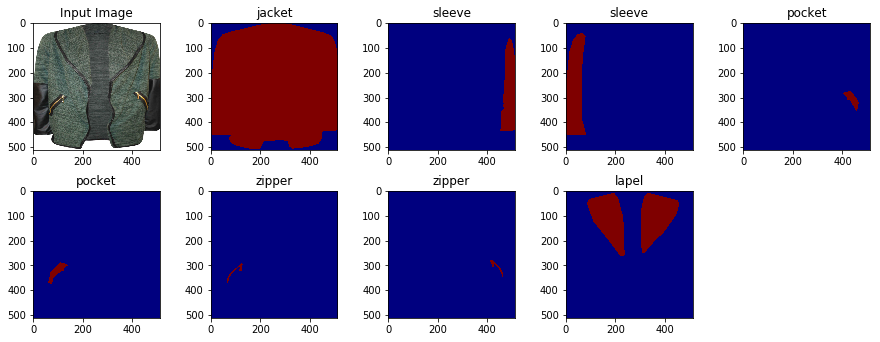

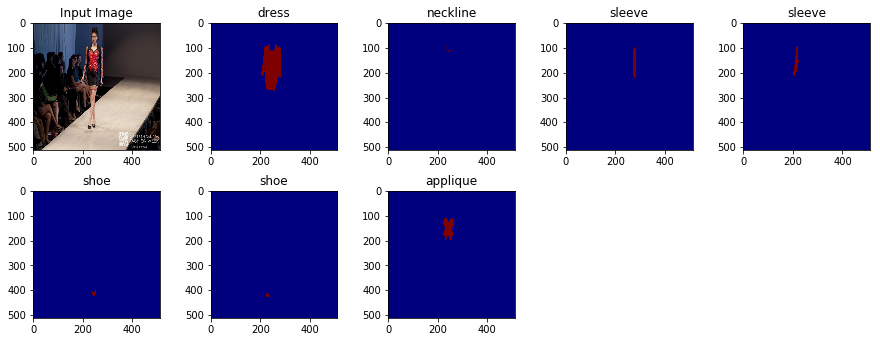

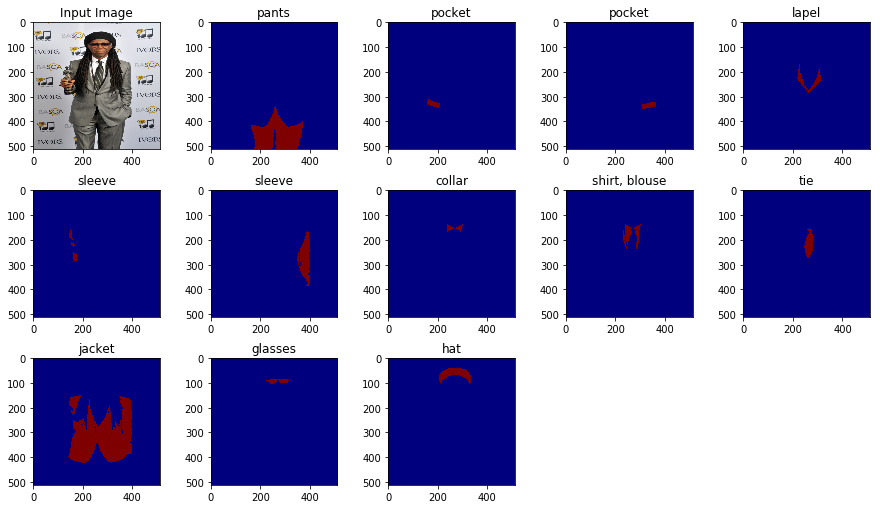

In [16]:
img_list = os.listdir('/kaggle/input/train/')
for k in img_list[:3]:
    cat_list1, mask_list1 = complete_make_mask(segment_df, k)
    plt.figure(figsize=[15,15])
    plt.subplot(3,5,1)
    show_img(k)
    plt.title('Input Image')
    i=1
    for mask, cat in zip(mask_list1, cat_list1):
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        plt.subplot(3,5,i+1)
        i+=1
        plt.imshow(mask,cmap='jet')
        plt.title(label_names[int(cat)])
    plt.subplots_adjust(wspace=0.4, hspace=-0.65)

In [17]:
seg_att_df = segment_df[[len(x)>0 for x in segment_df['AttributeId']]].reset_index(drop=['index'])

**Building apparel image and attribute data**

In [18]:
seg_att_df.iloc[30:50]

ImageId                 ...                                           AttributeId
30  0091ae902cb738e4ca06038c2654fa00.jpg                 ...                           [0, 14, 20, 42, 59, 65, 91]
31  0091ae902cb738e4ca06038c2654fa00.jpg                 ...                               [9, 20, 41, 59, 61, 91]
32  0091ae902cb738e4ca06038c2654fa00.jpg                 ...                                   [0, 20, 40, 60, 61]
33  0091ae902cb738e4ca06038c2654fa00.jpg                 ...                           [8, 15, 20, 31, 41, 46, 61]
34  009447b79fce7da1ee19a54401517cde.jpg                 ...                               [0, 20, 40, 60, 61, 88]
35  009447b79fce7da1ee19a54401517cde.jpg                 ...                           [0, 14, 20, 41, 46, 61, 91]
36  009447b79fce7da1ee19a54401517cde.jpg                 ...                           [2, 15, 20, 41, 46, 61, 88]
37  009d3fad34c4184fc93f3db4427bbf7a.jpg                 ...                           [3, 10, 20, 33, 60, 61, 91]
38  009f88701b43c02d0e9ca6464df6adba.jpg                 ...                           [3, 14, 20, 24, 52, 69, 87]
39  00c613d7ce33173d59b8661e2978049d.jpg                 ...                               [6, 14, 20, 32, 61, 87]
40  00d8ff3896fb7afe8d8bcef057d0820a.jpg                 ...                               [1, 20, 40, 49, 61, 91]
41  00f9f1089fa2061557eda585e6244d8f.jpg                 ...                           [3, 14, 20, 32, 60, 69, 86]
42  00f9f1089fa2061557eda585e6244d8f.jpg                 ...                           [0, 14, 20, 40, 60, 61, 88]
43  00fc1cb8809762f07f6237c96e42ac31.jpg                 ...                   [8, 14, 20, 36, 42, 52, 53, 61, 87]
44  00fc1cb8809762f07f6237c96e42ac31.jpg                 ...                               [0, 20, 40, 60, 61, 88]
45  011d12b27da7106a2740e325ae1d0dae.jpg                 ...                               [1, 20, 41, 60, 69, 88]
46  013365f6a05a669630d7a987289cdcb7.jpg                 ...                           [3, 14, 20, 33, 60, 69, 88]
47  01453b8281cbe6812b0dad94d98fbce7.jpg                 ...                           [0, 10, 20, 41, 60, 72, 88]
48  01453b8281cbe6812b0dad94d98fbce7.jpg                 ...                           [8, 15, 20, 30, 42, 60, 72]
49  0163795f5a1cb5b5adbd166a084e457a.jpg                 ...                           [6, 14, 20, 24, 53, 69, 87]

[20 rows x 7 columns]

In [19]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

# image_df = image_df.iloc[:10]
print("Total images: ", len(image_df))
image_df.head()


Total images:  45195


EncodedPixels  ...  Width
ImageId                                                                                  ...       
00000663ed1ff0c4e0132b9b9ac53f6e.jpg  [6068157 7 6073371 20 6078584 34 6083797 48 60...  ...   3676
0000fe7c9191fba733c8a69cfaf962b7.jpg  [2201176 1 2203623 3 2206071 5 2208518 8 22109...  ...   2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg  [2673735 2 2676734 8 2679734 13 2682733 19 268...  ...   1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg  [435 132 1002 132 1569 132 2136 132 2703 132 3...  ...    400
0004467156e47b0eb6de4aa6479cbd15.jpg  [132663 8 133396 25 134130 41 134868 53 135611...  ...    500

[5 rows x 4 columns]

Here is the custom function that resizes an image as per pre-trained Mask R-CNN model.

In [20]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

The crucial part is to create a dataset for this task.

In [21]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Let's visualize some random images and their masks.

('/kaggle/input/train/000aac3870ea7c59ca0333ffa5327323.jpg', ['dress', 'neckline', 'cardigan', 'sleeve', 'sleeve', 'neckline'])
mask_shape: (512, 512, 6)
img_shape: (512, 512, 3)
[11 34  4 32 32 34]
['BG', 'shirt', 'top', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights', 'sock', 'shoe', 'bag', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
47


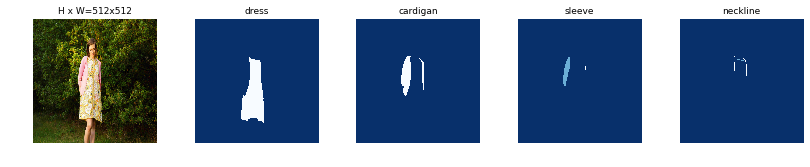

('/kaggle/input/train/000b3a87508b0fa185fbd53ecbe2e4c6.jpg', ['dress', 'neckline', 'bag, wallet'])
mask_shape: (512, 512, 3)
img_shape: (512, 512, 3)
[11 34 25]
['BG', 'shirt', 'top', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights', 'sock', 'shoe', 'bag', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
47


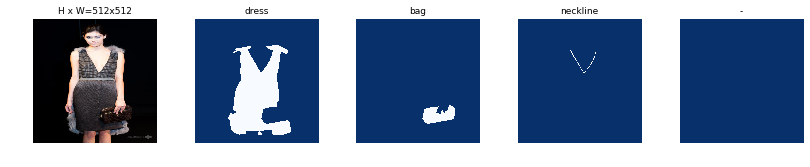

In [22]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(8,10):
#     image_id = random.choice(dataset.image_ids)
    image_id = dataset.image_ids[i]
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print('mask_shape:',mask.shape)
    print('img_shape:',image.shape)
    print(class_ids)
    print(dataset.class_names)
    print(len(dataset.class_names))
#     plt.figure()
#     plt.imshow(image)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Now, the data are partitioned into train and validation sets.

In [23]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total train images:  36156
Total train segments:  264949


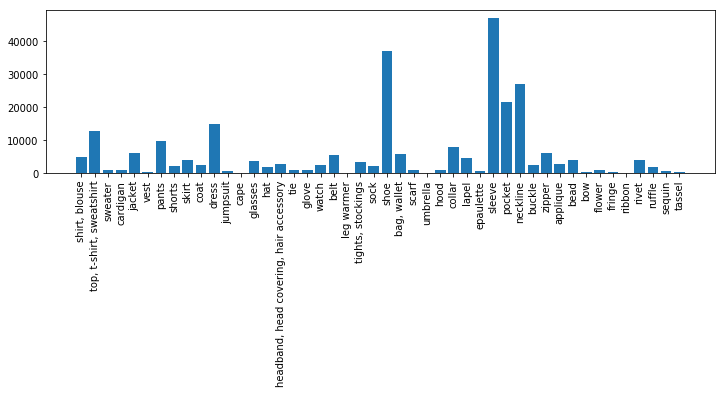

Total validation images:  9039
Total validation segments:  66264


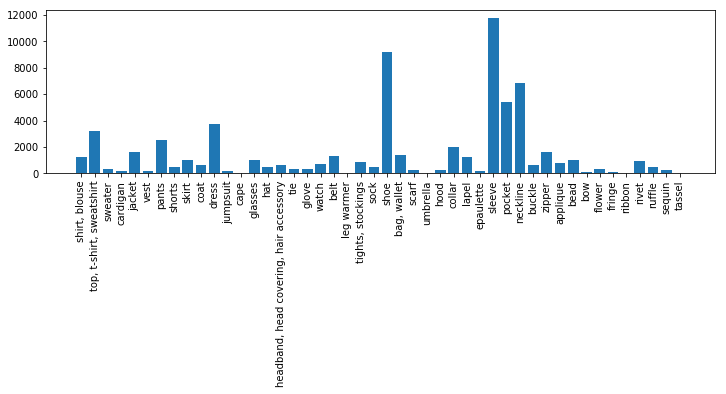

In [24]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()



# Train

In [25]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
# EPOCHS = [2, 6, 8]
EPOCHS = [1, 2, 3]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and specifies augmentations to be used.

In [26]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

First, we train only the heads.

In [28]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /kaggle/working/fashion20220729T1907/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

Then, all layers are trained.

In [29]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=0.0001

Checkpoint Path: /kaggle/working/fashion20220729T1907/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

Afterwards, we reduce LR and train again.

In [30]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/5,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=2e-05

Checkpoint Path: /kaggle/working/fashion20220729T1907/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

Let's visualize training history and choose the best epoch.

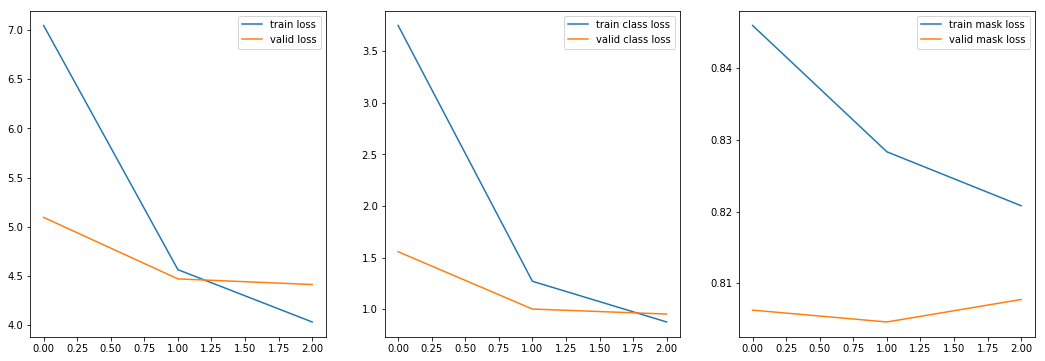

In [31]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [32]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  3
Valid loss:  4.41016697883606


# Predict

The final step is to use our model to predict test data.

In [33]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

This cell defines InferenceConfig and loads the best trained model.

In [34]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/fashion20220729T1907/mask_rcnn_fashion_0003.h5
Re-starting from epoch 3


Then, load the submission data.

In [35]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

Here is the main prediction steps, along with some helper functions.

In [36]:
sample_df['EncodedPixels'][0]

'1 1'

In [37]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [38]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [39]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

  8%|▊         | 245/3200 [03:33<37:02,  1.33it/s]  

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


The submission file is created, when all predictions are ready.

In [40]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  245
Missing Images:  230


ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

In [41]:
submission_df.to_csv("submission.csv", index=False)

Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.


*** No instances to display *** 



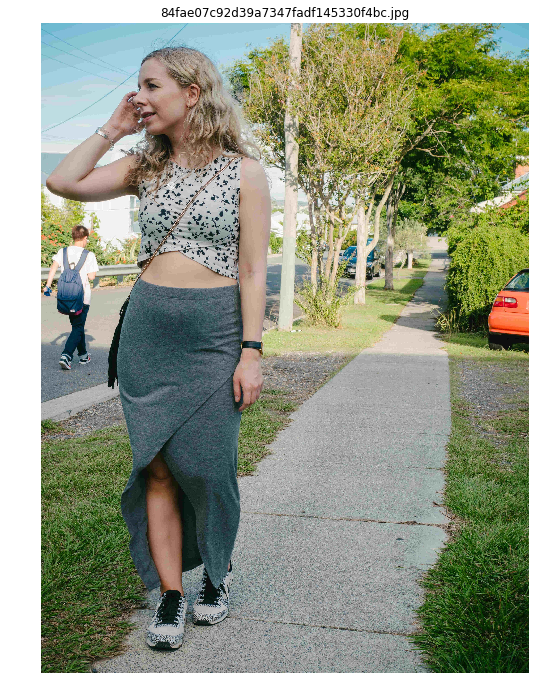


*** No instances to display *** 



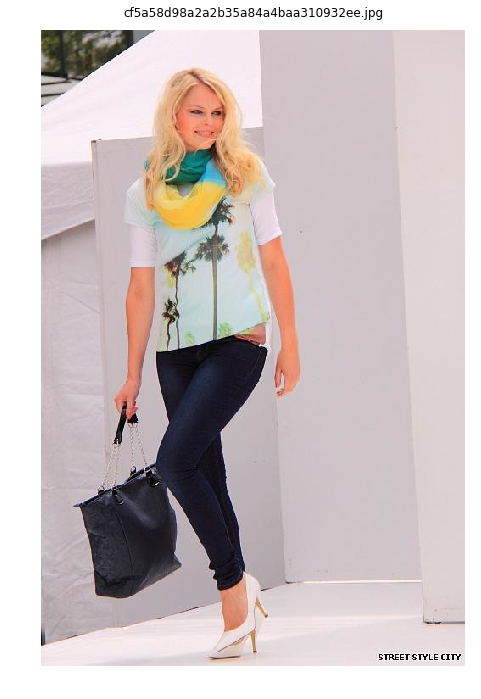


*** No instances to display *** 



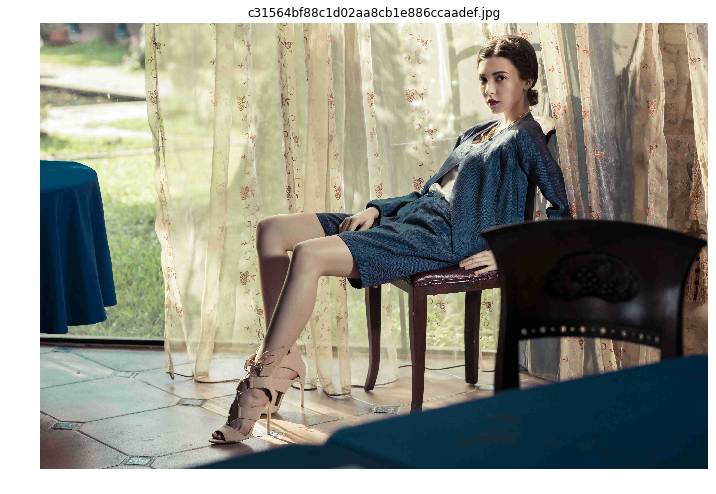

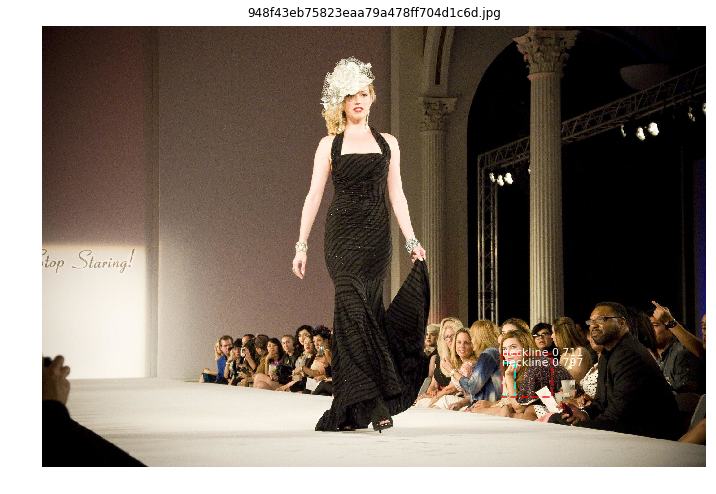


*** No instances to display *** 



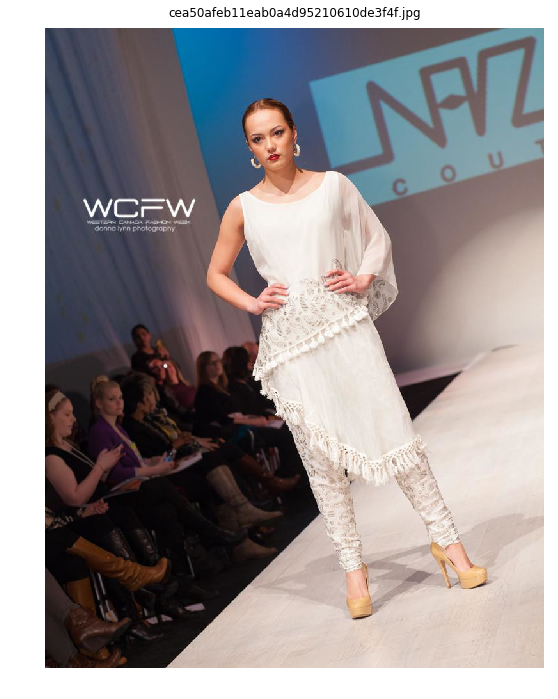


*** No instances to display *** 



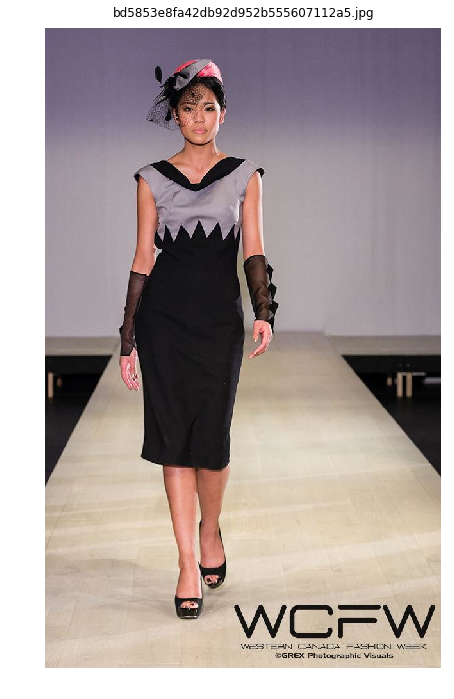


*** No instances to display *** 



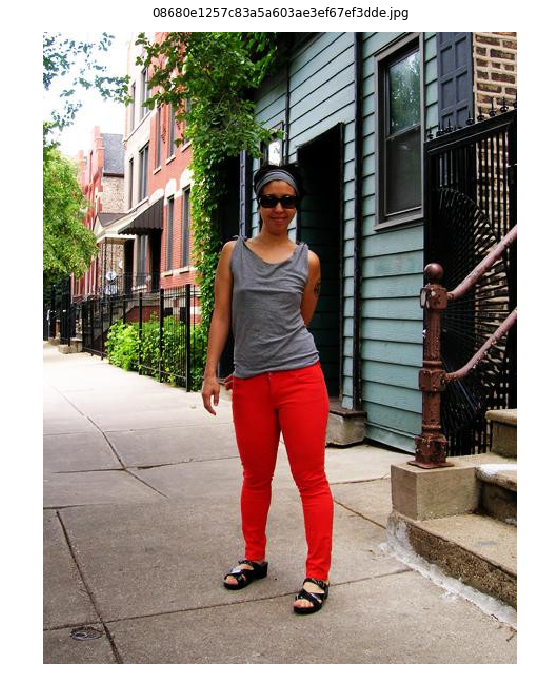


*** No instances to display *** 



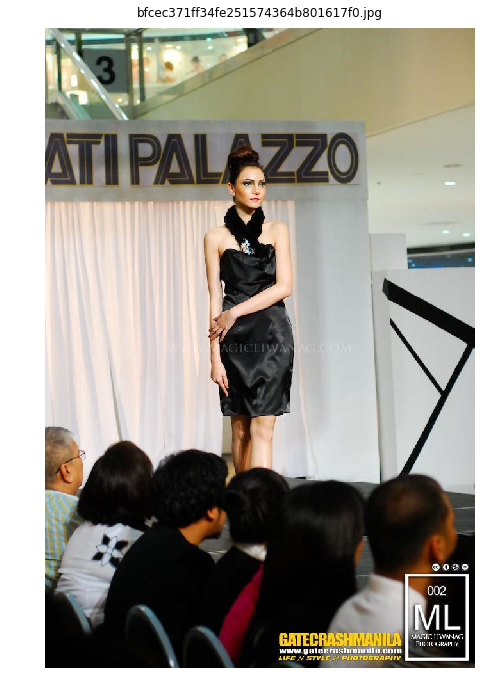


*** No instances to display *** 



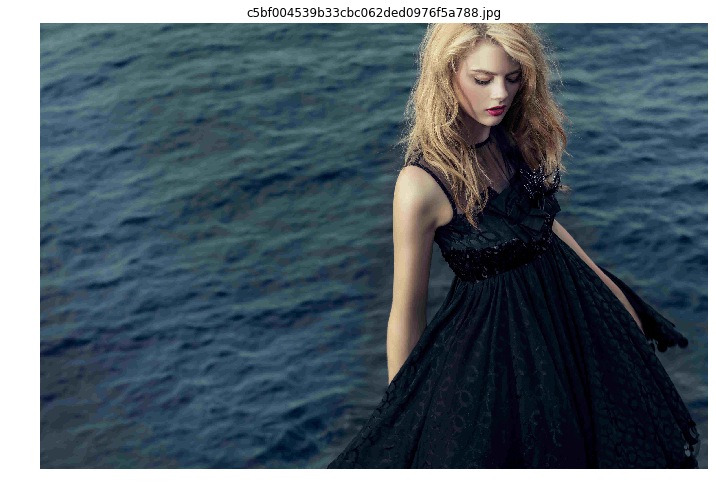

In [42]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

****Building Apparel attribute detection model****

In [49]:
def make_mask(data):
    df = data.reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
#     print("Correct Category :", int(df.CategoryId))
    # 1d mask 
    mask = np.full(H*W,dtype='int',fill_value = -1)
    
    for line in df[['EncodedPixels','CategoryId']].iterrows():
        # 1d mask 
#         mask = np.full(H*W,dtype='int',fill_value = -1)
        
        EncodedPixels = line[1][0]
        Category = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
        mask = mask.reshape(W,H).T
    return mask

In [51]:
IMAGE_SIZE2 = 299

***Saving the apparel images with attributes in different dataframes and image resizing as per InceptionV3 model***

In [52]:
img_id_list, apparel_img_list, cat_list, att_list = [], [], [],[]
apparel_id_list, att_id_list = [], []
# for i in range(seg_att_df.shape[0]):
for i in range(100):
#     if i%100==0:
    print(i)
    img_id_list+=[seg_att_df['ImageId'][i]]
    mask1 = make_mask(seg_att_df.iloc[i:i+1])
    mask1 = cv2.resize(mask1, (IMAGE_SIZE2, IMAGE_SIZE2), interpolation=cv2.INTER_NEAREST)  
    apparel_img_list+=[mask1]
    apparel_id_list+=[int(seg_att_df['CategoryId'][i])]
    cat_list+=[label_names[int(seg_att_df['CategoryId'][i])]]
    att_id_list+=[seg_att_df['AttributeId'][i]]
    att_list+=[[attribute_names[int(x)] for x in seg_att_df['AttributeId'][i]]]
image_att = pd.DataFrame({'ImageId':img_id_list,'ApparelImage':apparel_img_list,'ApparelId': apparel_id_list, 
                          'ApparelClass':cat_list,'AttributeId':att_id_list,'AttributeType':att_list})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [53]:
image_att.head()

ImageId                        ...                                                              AttributeType
0  000aac3870ea7c59ca0333ffa5327323.jpg                        ...                          [mini (length), symmetrical, a-line, cutout, f...
1  000aac3870ea7c59ca0333ffa5327323.jpg                        ...                          [hip (length), single breasted, symmetrical, r...
2  000b3a87508b0fa185fbd53ecbe2e4c6.jpg                        ...                          [knee (length), asymmetrical, straight, lining...
3  000e973c99dc090afd7898c93daf0dbc.jpg                        ...                          [above-the-hip (length), symmetrical, regular ...
4  000e973c99dc090afd7898c93daf0dbc.jpg                        ...                          [maxi (length), symmetrical, curved (fit), no ...

[5 rows x 6 columns]

Plotting apparel class and stating respect. attributes

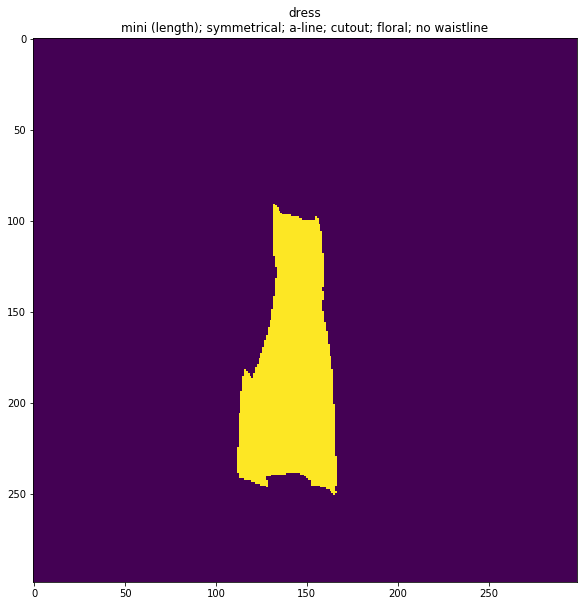

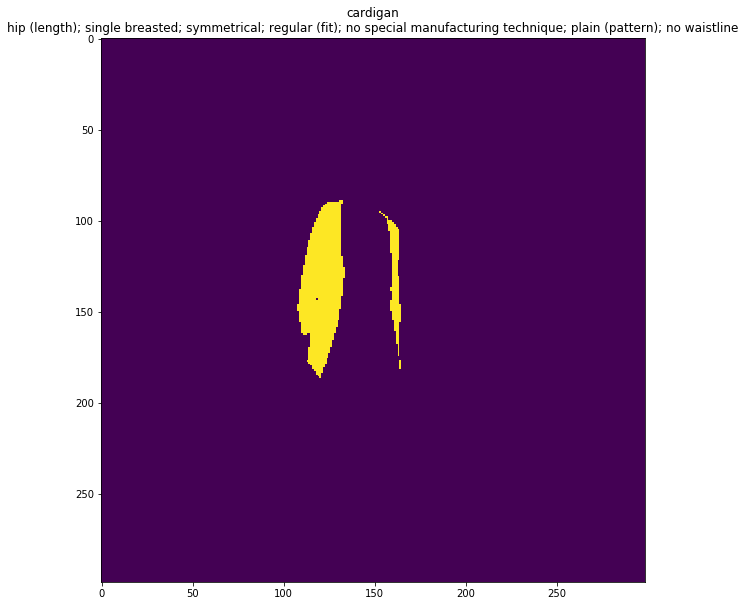

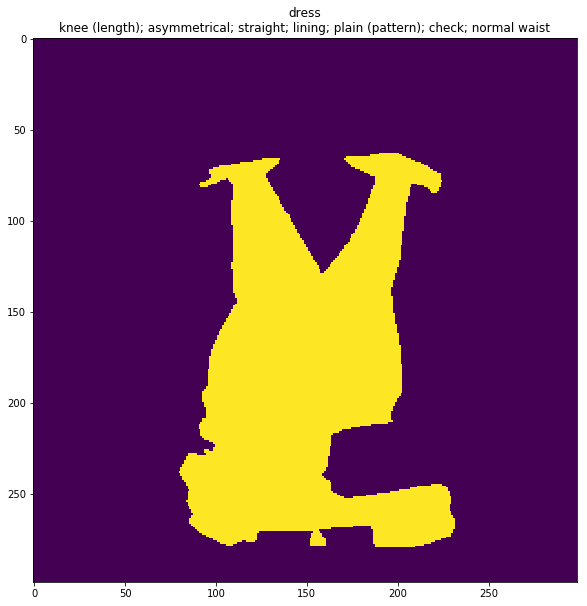

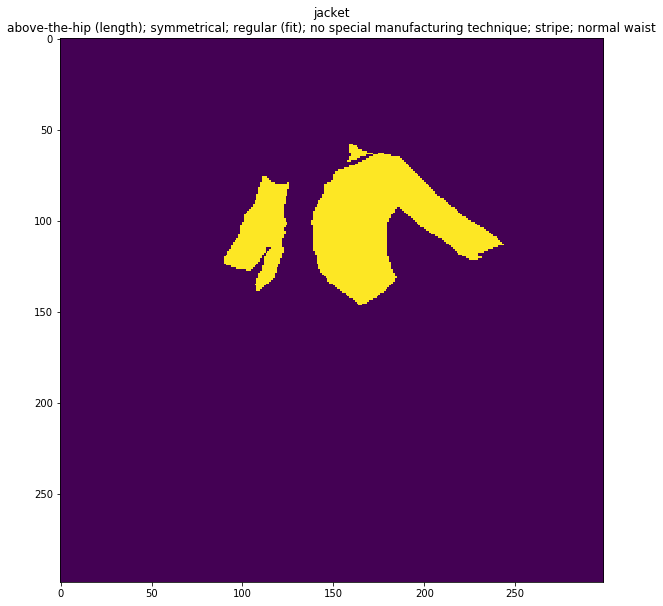

In [54]:
# for i in range(len(image_att)):
for i in range(4):
    plt.figure(figsize=[10,10])
    plt.imshow(image_att['ApparelImage'][i])
    plt.title(image_att['ApparelClass'][i]+'\n'+'; '.join(image_att['AttributeType'][i]))

Prepare Image feature vectors for Apparel class images

Using ImageNet pre-trained InceptionV3 model

In [55]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,Embedding,RepeatVector
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.models import Model
from pickle import dump, load
from keras.models import load_model
import numpy as np
inception = InceptionV3(weights='imagenet')

# pop the last softmax layer and freezing the remaining layers (re-structure the model)
inception.layers.pop()
#
for layer in inception.layers:
    layer.trainable = False

# building the final model
pre_trained_incept_v3 = Model(input = inception.input,output = inception.layers[-1].output)

96116736/96112376 [==============================] - 5s 0us/step


In [56]:
pre_trained_incept_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_16 

train-val data

In [57]:
msk = np.random.rand(len(image_att)) <= 0.8
train_att = image_att[msk].reset_index(drop=True)
val_att = image_att[~msk].reset_index(drop=True)

In [58]:
print(train_att.shape)
print(val_att.shape)

(77, 6)
(23, 6)


In [59]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,Embedding,RepeatVector
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

TARGET_SIZE = (299,299) # needed to convert the image as per pre-trained inceptionv3 requirements

img_feat_list = []
for i in range(len(train_att)):
    img = image_att['ApparelImage'][i]
    img = np.stack((img,)*3, axis=-1) # creating gray scale to 3-channel image
    # Converting image to array
    img_array = img_to_array(img)
    nimage = preprocess_input(img_array)
    # Adding one more dimesion
    nimage = np.expand_dims(nimage, axis=0)    
    fea_vec = pre_trained_incept_v3.predict(nimage)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    img_feat_list+=[fea_vec]
train_att['img_feat'] = img_feat_list

In [60]:
train_att['AttributeType'][0]

['mini (length)', 'symmetrical', 'a-line', 'cutout', 'floral', 'no waistline']

Preparing attribute (text) data

Total Apparel images:  77
All atributes throughout apparel images:  628


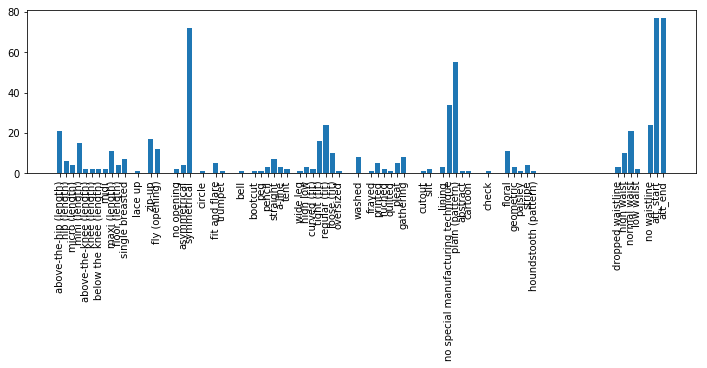

Max. number of attributes: 11
Feature vocab size: 46


In [61]:
from keras.preprocessing.text import Tokenizer
# as we'll be building it as image captioning model, we need to add some fixed start and end attributes"
train_att['AttributeId'] = [[92]+x+[93] for x in train_att['AttributeId']]
train_att['AttributeType'] = [['att_start']+x+['att_end'] for x in train_att['AttributeType']]

total_train_att = np.concatenate(train_att['AttributeId'].values).astype(int)
print("Total Apparel images: ", len(train_att))
print("All atributes throughout apparel images: ", len(total_train_att))

attribute_names+=['att_start','att_end']

plt.figure(figsize=(12, 3))
values, counts = np.unique(total_train_att, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, [attribute_names[x] for x in values], rotation='vertical')
plt.show()

#currently, dropping apparel attributes with freq. < 10
final_val = values[counts>=2]
final_att = [attribute_names[x] for x in final_val]

train_att['Final_att'] = [[x for x in z if x in final_att] for z in train_att['AttributeType']]

max_no = max([len(x) for x in train_att['Final_att']])
print('Max. number of attributes:', max_no)
vocab_size = len(final_att) + 1
print('Feature vocab size:', vocab_size)

ixtoword = {}
wordtoix = {}

ix = 1
for w in final_att:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
# token = Tokenizer(num_words=vocab_size)
# token.fit_on_texts(final_att)

In [62]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in final_att:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [63]:
wordtoix

{'above-the-hip (length)': 1,
 'hip (length)': 2,
 'micro (length)': 3,
 'mini (length)': 4,
 'above-the-knee (length)': 5,
 'knee (length)': 6,
 'below the knee (length)': 7,
 'midi': 8,
 'maxi (length)': 9,
 'floor (length)': 10,
 'single breasted': 11,
 'zip-up': 12,
 'fly (opening)': 13,
 'no opening': 14,
 'asymmetrical': 15,
 'symmetrical': 16,
 'fit and flare': 17,
 'pencil': 18,
 'straight': 19,
 'a-line': 20,
 'tent': 21,
 'high low': 22,
 'curved (fit)': 23,
 'tight (fit)': 24,
 'regular (fit)': 25,
 'loose (fit)': 26,
 'washed': 27,
 'printed': 28,
 'ruched': 29,
 'pleat': 30,
 'gathering': 31,
 'slit': 32,
 'lining': 33,
 'no special manufacturing technique': 34,
 'plain (pattern)': 35,
 'floral': 36,
 'geometric': 37,
 'stripe': 38,
 'dropped waistline': 39,
 'high waist': 40,
 'normal waist': 41,
 'low waist': 42,
 'no waistline': 43,
 'att_start': 44,
 'att_end': 45}

In [64]:
train_att.head()

ImageId                        ...                                                                  Final_att
0  000aac3870ea7c59ca0333ffa5327323.jpg                        ...                          [att_start, mini (length), symmetrical, a-line...
1  000aac3870ea7c59ca0333ffa5327323.jpg                        ...                          [att_start, hip (length), single breasted, sym...
2  000e973c99dc090afd7898c93daf0dbc.jpg                        ...                          [att_start, above-the-hip (length), symmetrica...
3  000e973c99dc090afd7898c93daf0dbc.jpg                        ...                          [att_start, maxi (length), symmetrical, curved...
4  000e973c99dc090afd7898c93daf0dbc.jpg                        ...                          [att_start, regular (fit), plain (pattern), at...

[5 rows x 8 columns]

Defininf encoder-decoder model

In [65]:
from keras.models import Model,Input
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Embedding,Dense,BatchNormalization,Dropout,LSTM,add
from keras.utils import plot_model

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

def combined_model(MAX_LENGTH,VOCAB_SIZE):
    "model parameters"
#    NPIX = 299 # required image shape for pre-trained inceptionnv3 model 
#    TARGET_SIZE = (NPIX,NPIX,3)
    EMBEDDING_SIZE = 256 #
    
    # partial caption sequence model    
    inputs2 = Input(shape=(MAX_LENGTH,))
    se1 = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(EMBEDDING_SIZE)(se2) 
    
    
    # image feature extractor model
    inputs1 = Input(shape=(2048,)) # iceptionnv3
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(EMBEDDING_SIZE, activation='relu')(fe1)
    
    
    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(EMBEDDING_SIZE, activation='relu')(decoder1) 
    #decoder2 = Dense(50, activation='relu')(decoder1) 
    outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)
    
    
    # merge the two input models
    # image_feature + partial caption ===> output
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    # setting wight of embedded matrix that we saved earlier for words
#     with open("embedding_matrix.pkl","rb") as f:
#         embedding_matrix = load(f)   
#     model.layers[2].set_weights([embedding_matrix])
#     model.layers[2].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

def data_generator(train_att, MAX_LENGTH,VOCAB_SIZE, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    for i in range(len(train_att)):
        n+=1
        photo = train_att['img_feat'][i]
        att_list = list(train_att['Final_att'][i])
        
        seq = [wordtoix[x] for x in att_list]
        for i in range(1,len(seq)):
            in_seq , op_seq = seq[:i],seq[i]
            #converting input sequence to fix length
            in_seq = pad_sequences([in_seq],maxlen=MAX_LENGTH,padding="post")[0]
            # converting op_seq to vocabulary size
#                    print(op_seq)
            op_seq = to_categorical([op_seq],num_classes=VOCAB_SIZE)[0]
#                    try:
#                        op_seq = to_categorical([op_seq],num_classes=VOCAB_SIZE)[0]
#                    except:
#                        op_seq = np.array([0]*VOCAB_SIZE)
            X1.append(photo)
            X2.append(in_seq)
            y.append(op_seq)
        # yield the batch data
        if n==num_photos_per_batch:
            yield [[np.array(X1), np.array(X2)], np.array(y)]
            X1, X2, y = list(), list(), list()
            n=0

max_length=200
                
# image feature extracted file
train_image_extracted = train_att['img_feat']

#"load train attributes
train_descriptions = train_att['Final_att']


model = combined_model(max_length, vocab_size) #

epochs = 10


len(train_descriptions)


for i in range(epochs):
    batch_size = number_pics_per_batch = 5
    steps = len(train_descriptions)//number_pics_per_batch
    generator = data_generator(train_att,max_length, vocab_size,number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

att_prediction_model = model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/1
15/15 [==============================] - 16s 1s/step - loss: 3.4201
Epoch 1/1
15/15 [==============================] - 7s 473ms/step - loss: 3.0034
Epoch 1/1
15/15 [==============================] - 6s 404ms/step - loss: 2.5962
Epoch 1/1
15/15 [==============================] - 6s 421ms/step - loss: 2.2637
Epoch 1/1
15/15 [==============================] - 6s 420ms/step - loss: 2.0055
Epoch 1/1
15/15 [==============================] - 6s 404ms/step - loss: 1.7682
Epoch 1/1
15/15 [==============================] - 7s 467ms/step - loss: 1.6006
Epoch 1/1
15/15 [==============================] - 6s 403ms/step - loss: 1.3664
Epoch 1/1
15/15 [==============================] - 6s 412ms/step - loss: 1.2193
Epoch 1/1
15/15 [==============================] - 6s 398ms/step - loss: 1.0805


In [66]:
att_prediction_model = model

Prediction on new apparel

In [81]:
from mrcnn import visualize
# extract features from each photo in the directory
def extract_features(img):
    plt.imshow(img)
    img = np.stack((img,)*3, axis=-1) # creating gray scale to 3-channel image
    # Converting image to array
    img_array = img_to_array(img)
    nimage = preprocess_input(img_array)
    # Adding one more dimesion
    nimage = np.expand_dims(nimage, axis=0)    
    fea_vec = pre_trained_incept_v3.predict(nimage)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


# generate a description for an image
def generate_desc(model, photo, max_length):
    # seed the generation process
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))
    sequence = ['att_start']
    photo = photo.reshape(1,2048)

    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        seq = [wordtoix[x] for x in sequence]
        # pad input
        seq1 = pad_sequences([seq], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,seq1], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        sequence+=[word]
        # stop if we predict the end of the sequence
        if word == 'att_end':
            break
    return sequence
        
 

"prediction on new images"
val_att = train_att.copy()



for i in range(3):
    print(i)
    img = val_att['ApparelImage'][i]
    
    print(img)
    plt.figure()
    plt.imshow(img)
    photo = extract_features(img)
    description = generate_desc(att_prediction_model, photo, max_length)
    plt.title('pred. apparel attributes:\n'+'; '.join([x for x in description if x not in ['att_start', 'att_end']]))
    
    
    


0


NameError: name 'display_images' is not defined

FileNotFoundError: [Errno 2] No such file or directory: 'IMAGE_DIR/input/imaterialist-fashion-2019-FGVC6/train/000e973c99dc090afd7898c93daf0dbc.jpg'